# Classificação - Dados Abertos da PRF

## Carregando as bibliotecas

In [49]:
import textwrap

import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier


from matplotlib 		   import colormaps

## Carregando o dataset

In [50]:
datatran = pd.read_csv(
	"../dataset/prf/acidentes2024_todas_causas_tipos.csv",
	sep		 = ";",
	encoding = "latin1"
)

In [51]:
datatran.shape

(603215, 37)

## Preprocessamento do dataset

## Limpeza

In [52]:
datatran.columns

Index(['id', 'pesid', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br',
       'km', 'municipio', 'causa_principal', 'causa_acidente',
       'ordem_tipo_acidente', 'tipo_acidente', 'classificacao_acidente',
       'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista',
       'tracado_via', 'uso_solo', 'id_veiculo', 'tipo_veiculo', 'marca',
       'ano_fabricacao_veiculo', 'tipo_envolvido', 'estado_fisico', 'idade',
       'sexo', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos',
       'latitude', 'longitude', 'regional', 'delegacia', 'uop'],
      dtype='object')

Descartanto características irrelevantes para a análise

In [53]:
irrelevantFeatures = [
	"id",
	"pesid",
	"data_inversa",
	"horario",
	"uf",
	"br",
	"km",
	"municipio",
	"sentido_via",
	"tracado_via",
	"id_veiculo",
	"marca",
	"ano_fabricacao_veiculo",
	"ilesos",
	"feridos_leves",
	"feridos_graves",
	"mortos",
	"latitude",
	"longitude",
	"regional",
	"delegacia",
	"uop",
	"dia_semana",
	"idade",
	"ordem_tipo_acidente",
    "causa_acidente"
]

In [54]:
datatran = datatran.drop(columns = irrelevantFeatures)

In [55]:
datatran.head()

,causa_principal,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tipo_pista,uso_solo,tipo_veiculo,tipo_envolvido,estado_fisico,sexo
0,Sim,Colisão com objeto,Com Vítimas Fatais,Plena Noite,Céu Claro,Dupla,Sim,Motocicleta,Condutor,Óbito,Masculino
1,Não,Colisão com objeto,Sem Vítimas,Plena Noite,Céu Claro,Dupla,Não,Automóvel,Condutor,Ileso,Feminino
2,Sim,Colisão com objeto,Sem Vítimas,Plena Noite,Céu Claro,Dupla,Não,Automóvel,Condutor,Ileso,Feminino
3,Sim,Colisão com objeto,Sem Vítimas,Plena Noite,Nublado,Múltipla,Sim,Caminhonete,Condutor,Ileso,Masculino
4,Não,Saída de leito carroçável,Com Vítimas Feridas,Plena Noite,Chuva,Dupla,Não,Camioneta,Condutor,Ileso,Masculino


In [56]:
datatran.shape

(603215, 11)

Removendo linhas com valores vazios

In [57]:
datatran = datatran.dropna()

In [58]:
datatran.shape

(526000, 11)

Removendo linhas com sexo igual a Ignorado

In [59]:
datatran = datatran[
	(datatran['sexo'] != 'Não Informado') &
	(datatran['sexo'] != 'Ignorado')
]


In [60]:
datatran.shape

(500605, 11)

Atribuição compreensiva do 'uso_solo'

In [61]:
datatran['uso_solo'] = datatran['uso_solo'].str.replace("Sim", "Urbano")
datatran['uso_solo'] = datatran['uso_solo'].str.replace("Não", "Rural")

## Codificação das variáveis categóricas

Codificação da variável alvo

In [62]:
targetLabel = pd.DataFrame(index = datatran.index)

In [63]:
targetLabel['label'] = datatran['causa_principal']

targetLabel['label'] = targetLabel['label'].str.replace("Sim", "1")
targetLabel['label'] = targetLabel['label'].str.replace("Não", "0")

targetLabel['label'] = targetLabel['label'].astype(int).astype(bool)


In [64]:
targetLabel.value_counts()

label
True     287854
False    212751
Name: count, dtype: int64

In [65]:
targetLabel.shape

(500605, 1)

Aplicando One Hot Encoding

In [66]:
encoder = OneHotEncoder(sparse_output = False)

In [67]:
oneHotFeatures = encoder.fit_transform(
    X = datatran.drop(columns = ['causa_principal'])
)

oneHotFeatures.shape

(500605, 72)

In [68]:
oneHotFeatures = pd.DataFrame(
	data    = oneHotFeatures,
	columns = encoder.get_feature_names_out(),
	dtype   = bool
)

In [69]:
datatranEncoded = pd.concat(
    [targetLabel.reset_index(drop = True), oneHotFeatures.reset_index(drop = True)],
    axis = 1
)

In [70]:
datatranEncoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500605 entries, 0 to 500604
Data columns (total 73 columns):
 #   Column                                        Non-Null Count   Dtype
---  ------                                        --------------   -----
 0   label                                         500605 non-null  bool 
 1   tipo_acidente_Atropelamento de Animal         500605 non-null  bool 
 2   tipo_acidente_Atropelamento de Pedestre       500605 non-null  bool 
 3   tipo_acidente_Capotamento                     500605 non-null  bool 
 4   tipo_acidente_Colisão com objeto              500605 non-null  bool 
 5   tipo_acidente_Colisão frontal                 500605 non-null  bool 
 6   tipo_acidente_Colisão lateral mesmo sentido   500605 non-null  bool 
 7   tipo_acidente_Colisão lateral sentido oposto  500605 non-null  bool 
 8   tipo_acidente_Colisão transversal             500605 non-null  bool 
 9   tipo_acidente_Colisão traseira                500605 non-null  bool 
 

Normalização do dataset codificado

In [71]:
featuresEncoded = datatranEncoded.columns[
    ~datatranEncoded.columns.isin(values = ['label'])
]

In [72]:
scaler = StandardScaler()

datatranEncoded[featuresEncoded] = scaler.fit_transform(datatranEncoded[featuresEncoded])

## Analise Exploratória

Proporções dos valores categórios em cada coluna

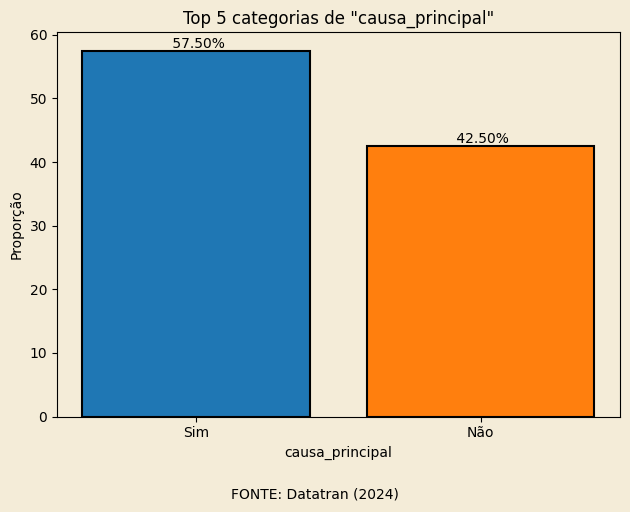

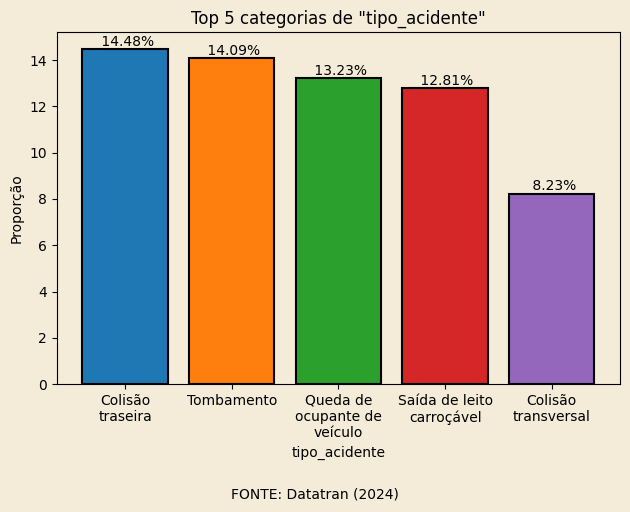

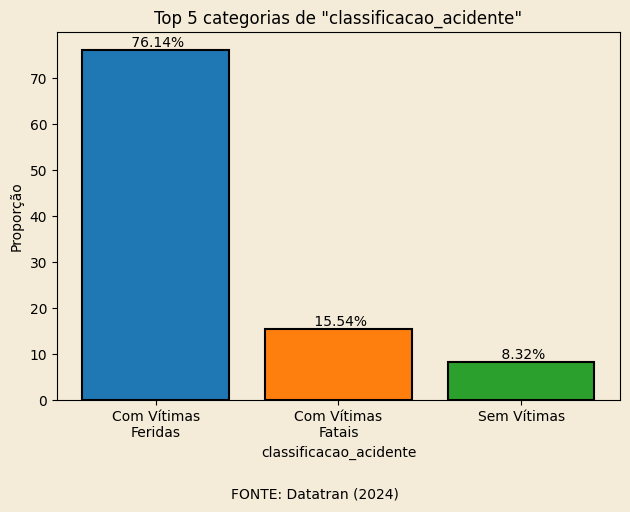

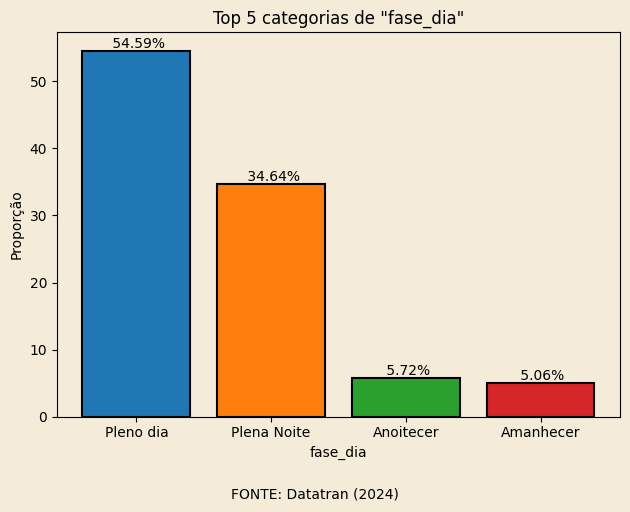

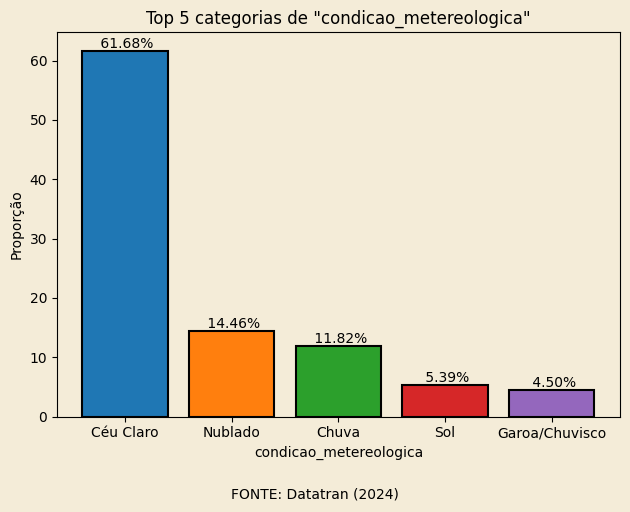

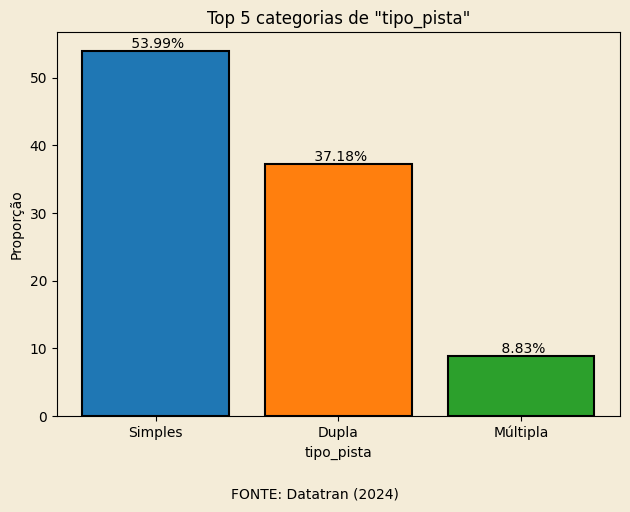

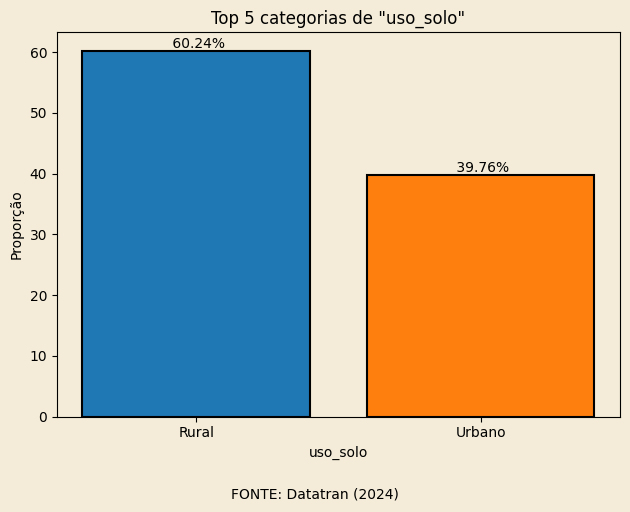

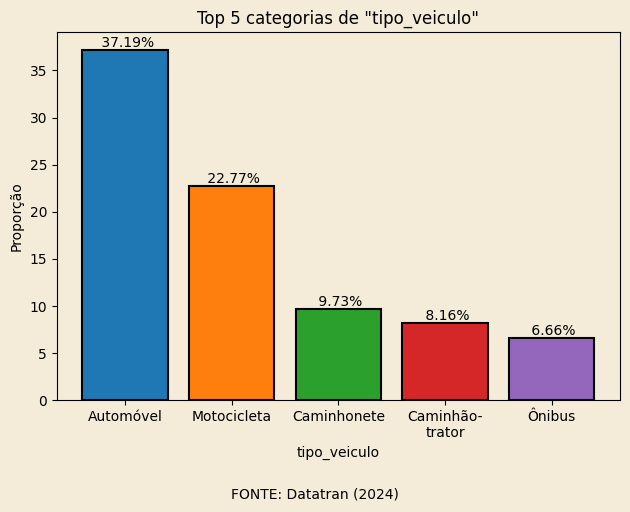

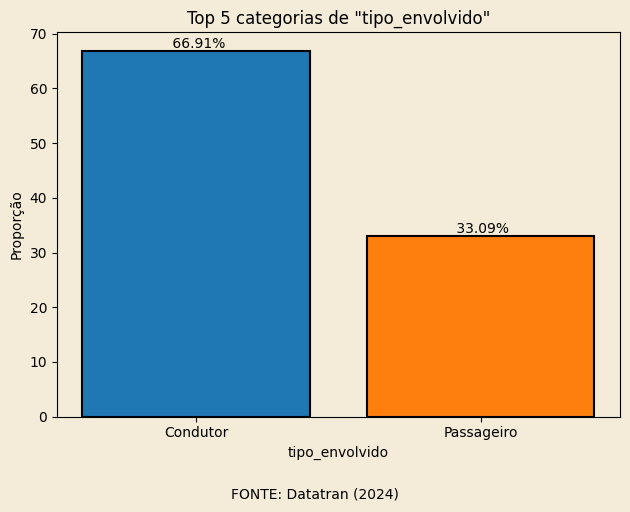

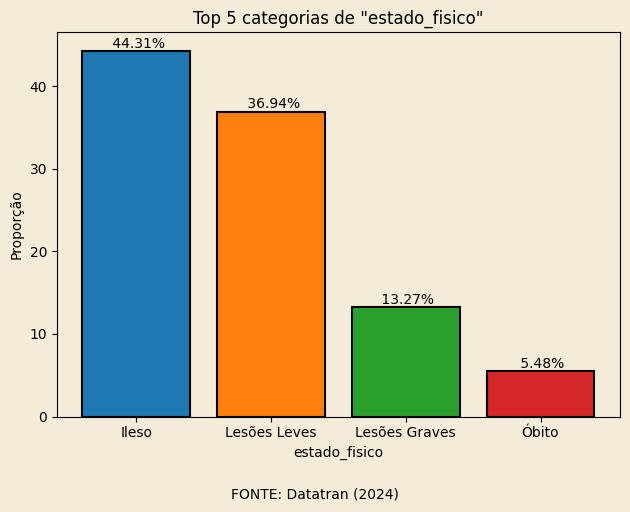

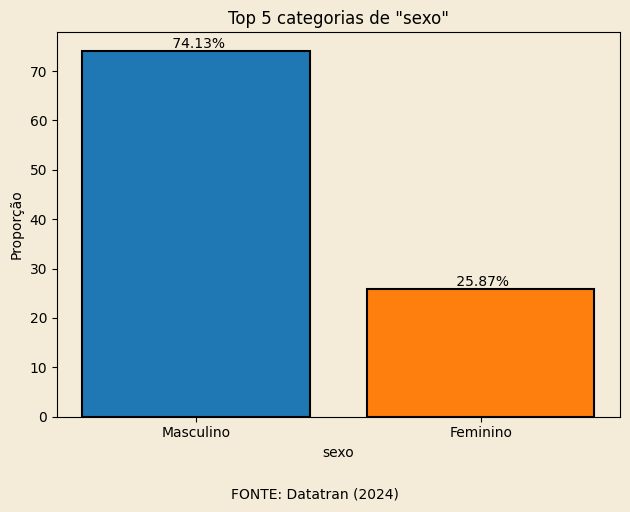

In [73]:
top = 5

for feature in datatran.columns:
	
	proportions = datatran[feature]\
		.value_counts(normalize = True, ascending = False)[:top]\
		.reset_index()
	
	proportions.columns = ['Categoria', 'Proporção']

	labels = [textwrap.fill(str(label), width = 14) for label in proportions['Categoria']]

	figure = plt.figure()


	plt.title(f'Top {top} categorias de "{feature}"')

	bars = plt.bar(
		x         = proportions['Categoria'],
		height    = proportions['Proporção'] * 100,
		color     = colormaps.get('tab10').colors,
		edgecolor = 'black',
		linewidth = 1.5

	)

	figure.set_facecolor("#F4ECD8")
	figure.axes[0].set_facecolor("#F4ECD8")

	for i, bar in enumerate(bars):

		height = bar.get_height()

		plt.text(
			i,                   
			height + 0.01,          
			f'{height: .2f}%', 
			ha       = 'center',    
			va       = 'bottom',    
			fontsize = 10
		)

	plt.xlabel(feature)
	plt.ylabel('Proporção')

	plt.xticks(
		ticks  = range(len(labels)), 
		labels = labels
	)

	plt.figtext(
		0.5, -0.05,                 
		'FONTE: Datatran (2024)',  
		horizontalalignment = 'center',
		fontsize            = 10
	)

	plt.tight_layout()

	plt.show()
	plt.close()

Proporções dos valores categórios em cada coluna dada a causa principal

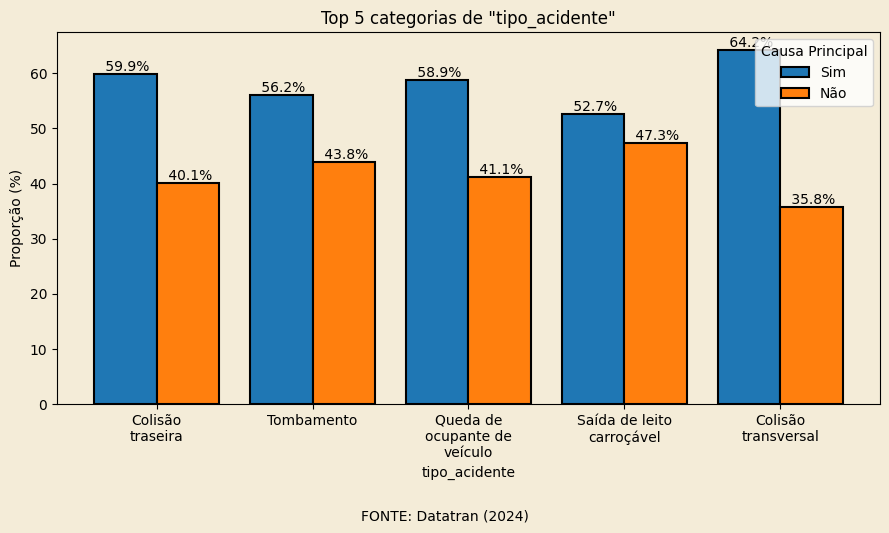

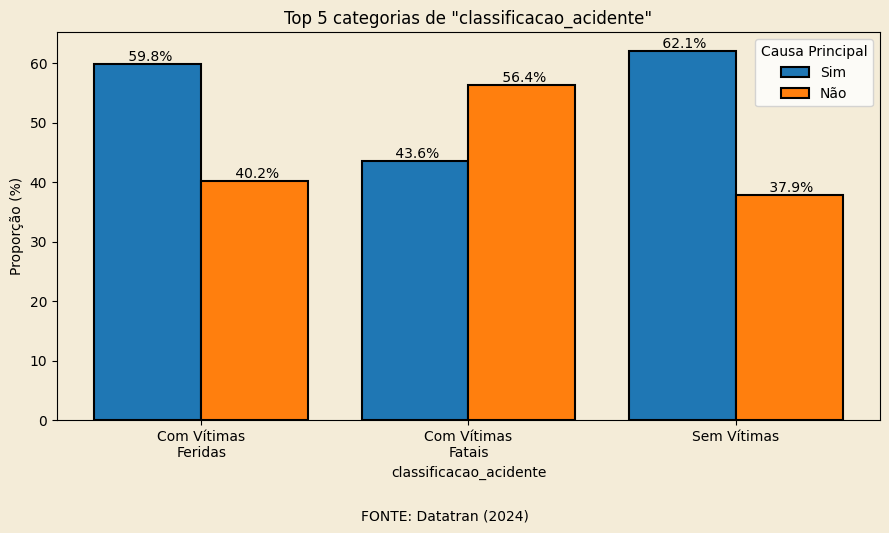

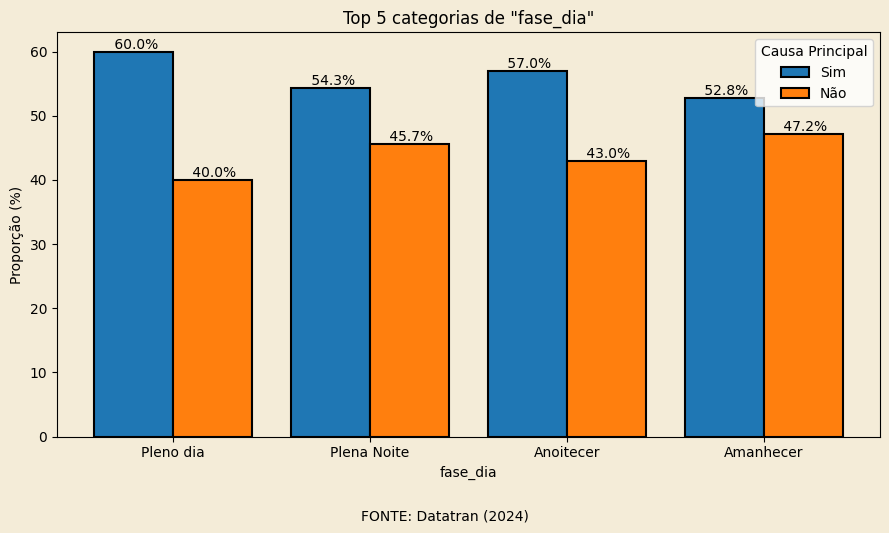

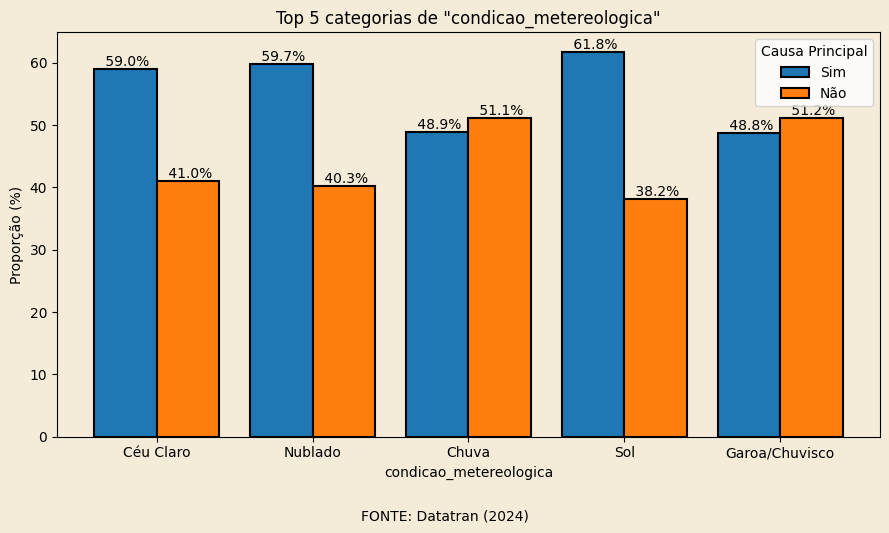

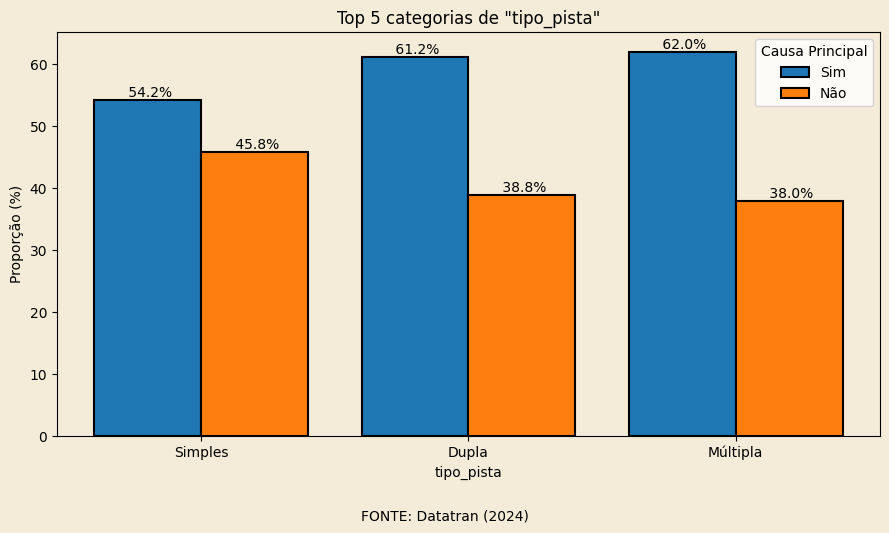

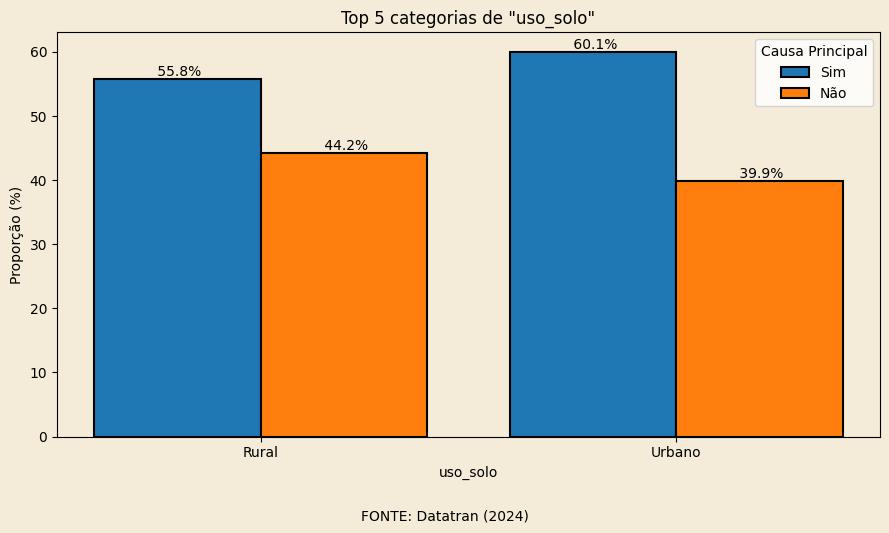

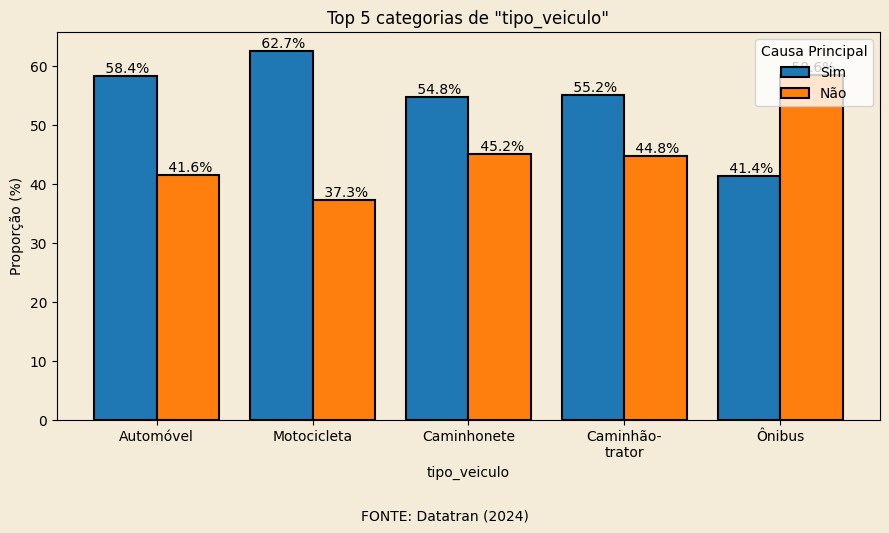

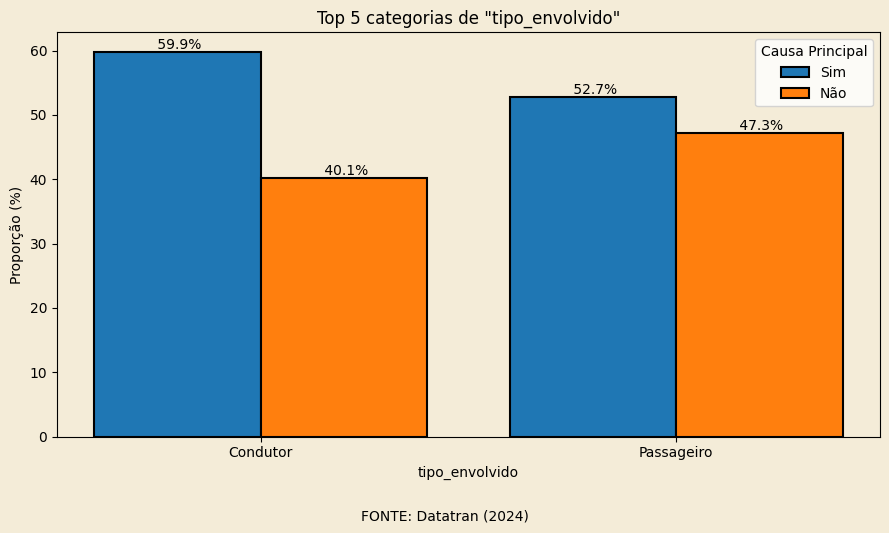

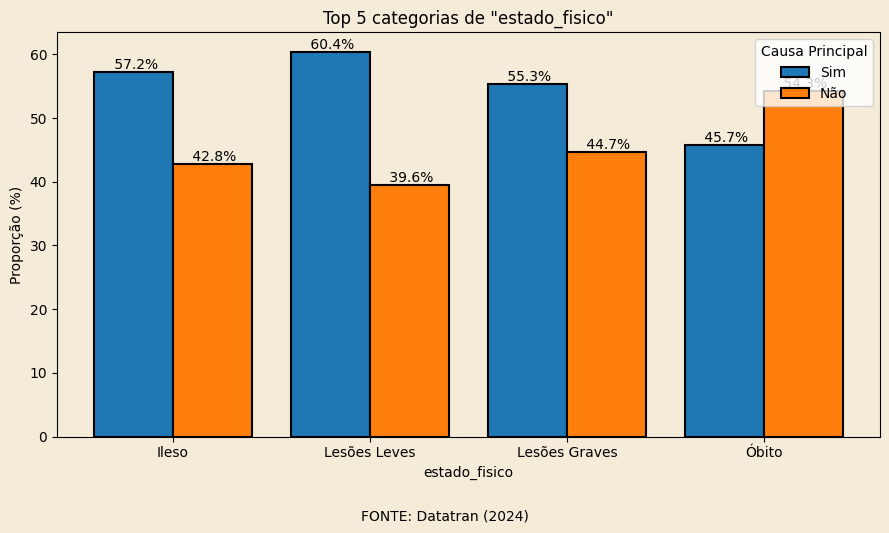

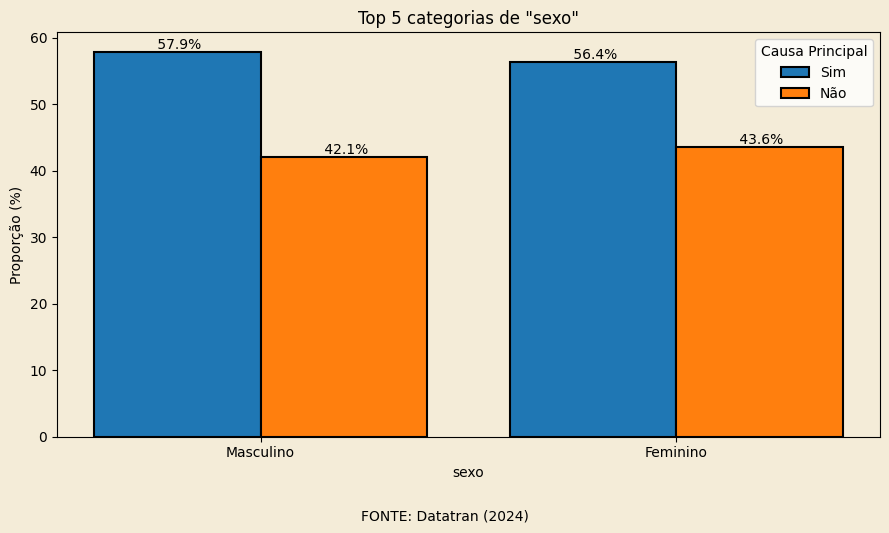

In [74]:
top = 5

for feature in datatran.columns:

	if feature == 'causa_principal':
		continue

	topCategories       = datatran[feature].value_counts(normalize=True)[:top].index
	topCategoriesFilter = datatran[datatran[feature].isin(topCategories)]

	count = (
		topCategoriesFilter
		.groupby([feature, 'causa_principal'])
		.size()
		.reset_index(name = 'Contagem')
	)

	count['Proporcao'] = (
		count
		.groupby(feature)['Contagem']
		.transform(lambda x: x / x.sum()) * 100
	)

	count[feature] = pd.Categorical(
		count[feature], 
		categories = topCategories, 
		ordered    = True
	)
	
	count  = count.sort_values(by = feature)
	labels = [textwrap.fill(str(label), width=14) for label in topCategories]

	figure, axes = plt.subplots(figsize = (9, 5))
	
	figure.set_facecolor("#F4ECD8")
	axes.set_facecolor("#F4ECD8")

	barWidth = 0.4
	x = range(len(topCategories))

	for i, value in enumerate(['Sim', 'Não']):
		
		groups    = count[count['causa_principal'] == value]
		ṕositions = [j + (i - 0.5) * barWidth for j in x]

		axes.bar(
			ṕositions,
			groups['Proporcao'],
			width     = barWidth,
			label     = value,
			color     = colormaps.get('tab10').colors[i],
			edgecolor = 'black',
			linewidth = 1.5
		)

		for xi, yi in zip(ṕositions, groups['Proporcao']):
			axes.text(
				xi, yi,
				f'{yi: .1f}%',
				ha       = 'center',
				va       = 'bottom',
				fontsize =  10
			)

	axes.set_title(f'Top {top} categorias de "{feature}"')
	
	axes.set_xlabel(feature)
	axes.set_ylabel('Proporção (%)')
	
	axes.set_xticks(x)
	axes.set_xticklabels(labels)
	
	axes.legend(title = 'Causa Principal')

	plt.figtext(
		0.5, -0.05,
		'FONTE: Datatran (2024)',
		horizontalalignment = 'center',
		fontsize            = 10
	)

	plt.tight_layout()
	plt.show()
	plt.close()


## Seleção dos atributos


Aplicando PCA

In [75]:
pcaVariance = .90
pca 		= PCA(n_components = pcaVariance)

In [76]:
datatranPCAData = pca.fit_transform(datatranEncoded[featuresEncoded])
featuresPCA     = [f'v{i}' for i in range(pca.n_components_)]

In [77]:
datatranPCA = pd.DataFrame(
    columns = featuresPCA,
    data    = datatranPCAData
)
datatranPCA['label'] = datatranEncoded['label']

In [78]:
print(f"{pca.n_components_} componentes para {pcaVariance: .2f} da variância") 

53 componentes para  0.90 da variância


## Hold out do dataset

In [79]:
X = datatranPCA[featuresPCA]
y = datatranPCA['label']

In [80]:
XTrain, XTest, yTrain, yTest = train_test_split(
    X,
    y,
    train_size   = .70,
    stratify     = y,
    random_state = 42
)

## Treinamento do modelo

1. Realize a validação cruzada usando o KFold com $k = 10$
1. Treine o modelo com todo o dataset de Treino

In [91]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'HistGradientBoost': HistGradientBoostingClassifier(random_state=42)
}

trained_models = {}
print("--- Iniciando o Treinamento dos Modelos ---")

for name, model in models.items():
    print(f"Treinando o modelo: {name}...")
    model.fit(XTrain, yTrain)
    trained_models[name] = model
    print(f"{name} treinado com sucesso!")

print("\n--- Todos os modelos foram treinados! ---")

--- Iniciando o Treinamento dos Modelos ---
Treinando o modelo: Decision Tree...
Decision Tree treinado com sucesso!
Treinando o modelo: Random Forest...
Random Forest treinado com sucesso!
Treinando o modelo: HistGradientBoost...
HistGradientBoost treinado com sucesso!

--- Todos os modelos foram treinados! ---


## Teste do modelo

1. Teste o modelo

In [92]:
predictions = {}

print("--- Gerando previsões no conjunto de teste ---")

for name, model in trained_models.items():
    print(f"Gerando previsões para o modelo: {name}...")
    y_pred = model.predict(XTest)
    predictions[name] = y_pred
    print("Previsões geradas.")

print("\n--- Previsões concluídas para todos os modelos! ---")

--- Gerando previsões no conjunto de teste ---
Gerando previsões para o modelo: Decision Tree...
Previsões geradas.
Gerando previsões para o modelo: Random Forest...
Previsões geradas.
Gerando previsões para o modelo: HistGradientBoost...
Previsões geradas.

--- Previsões concluídas para todos os modelos! ---


# Avaliação do modelo

1. Gere a curva ROC
1. Gere a tabela de confusão
1. Gere outros métricas que desejar

Relatório de Classificação do modelo Decision Tree:
              precision    recall  f1-score   support

       False       0.51      0.41      0.45     63826
        True       0.62      0.71      0.66     86356

    accuracy                           0.58    150182
   macro avg       0.56      0.56      0.56    150182
weighted avg       0.57      0.58      0.57    150182

Relatório de Classificação do modelo Random Forest:
              precision    recall  f1-score   support

       False       0.52      0.37      0.43     63826
        True       0.62      0.75      0.68     86356

    accuracy                           0.59    150182
   macro avg       0.57      0.56      0.55    150182
weighted avg       0.58      0.59      0.57    150182

Relatório de Classificação do modelo HistGradientBoost:
              precision    recall  f1-score   support

       False       0.59      0.27      0.37     63826
        True       0.61      0.86      0.72     86356

    accuracy          

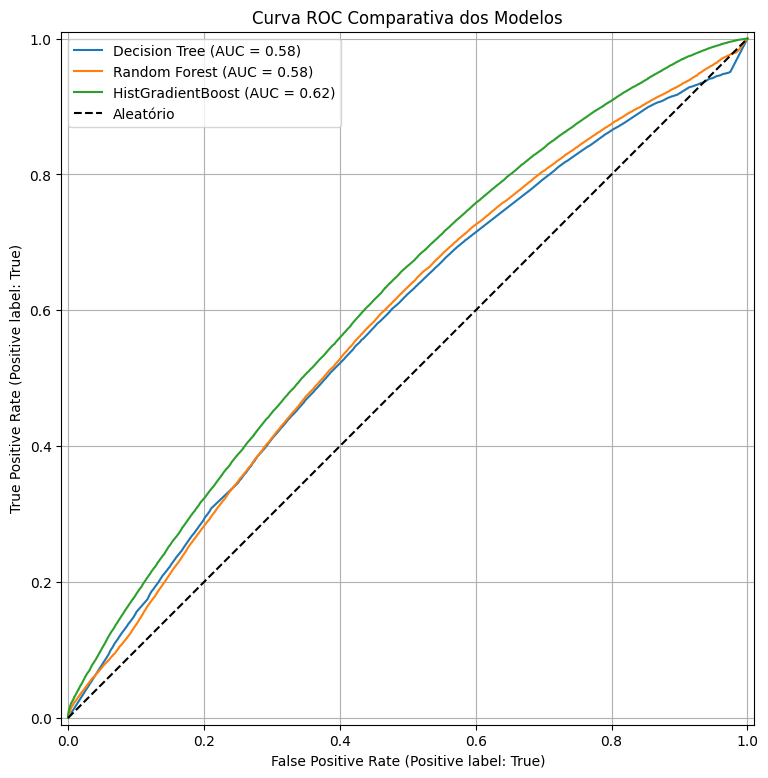

In [93]:
plt.figure(figsize=(12, 9))
ax = plt.gca()

for name, model in trained_models.items():
    
    y_pred = model.predict(XTest)
        
    print(f"Relatório de Classificação do modelo {name}:")
    print(classification_report(yTest, y_pred)) 
        
    RocCurveDisplay.from_estimator(model, XTest, yTest, name=name, ax=ax)
        
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.title('Curva ROC Comparativa dos Modelos')
plt.legend()
plt.grid(True)
plt.show()


--- Análise Detalhada do Modelo: HistGradientBoost ---

Tabela de Confusão (em Porcentagens):


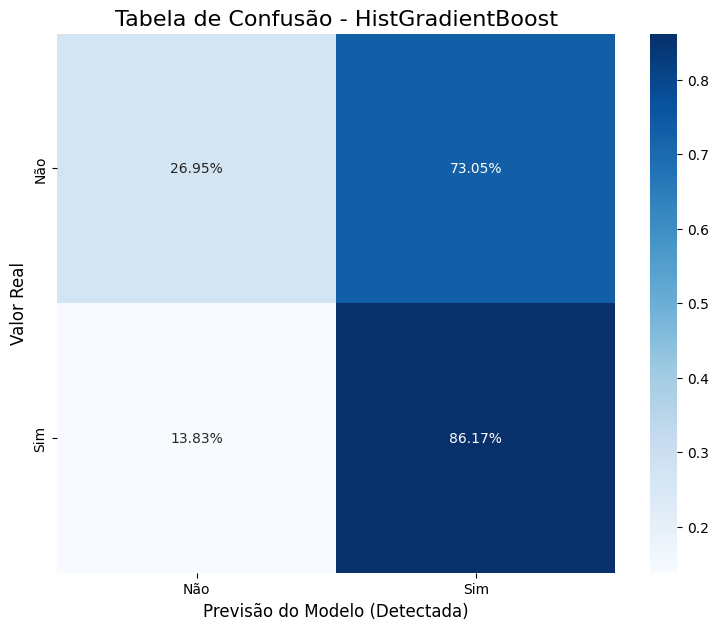

In [94]:
nome_do_melhor_modelo = 'HistGradientBoost' 

print(f"\n--- Análise Detalhada do Modelo: {nome_do_melhor_modelo} ---")

best_model = trained_models[nome_do_melhor_modelo]
y_pred_best = best_model.predict(XTest)

print("\nTabela de Confusão (em Porcentagens):")
cm = confusion_matrix(yTest, y_pred_best, labels=[False, True])

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels_grafico = ['Não', 'Sim'] 

plt.figure(figsize=(9, 7))

sns.heatmap(
    cm_percent,         
    annot=True,         
    fmt='.2%',          
    cmap='Blues',
    xticklabels=labels_grafico,
    yticklabels=labels_grafico,
)
# -----------------------------

plt.xlabel('Previsão do Modelo (Detectada)', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.title(f'Tabela de Confusão - {nome_do_melhor_modelo}', fontsize=16)
plt.show()